<a href="https://colab.research.google.com/github/PetrisGR/EKPA/blob/main/FeatureImportance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Εισαγωγή των απαραίτητων βιβλιοθηκών
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
# Φόρτωση του συνόλου δεδομένων
url = 'https://github.com/kdemertzis/EKPA/raw/main/Data/DarkNet.csv'
data = pd.read_csv(url, low_memory=False)

In [4]:
## Προεπεξεργασία συνόλου δεδομένων

# Καθαρισμός των δεδομένων: Αντικατάσταση των μη αριθμητικών τιμών με NaN
data.replace('?', np.nan, inplace=True)

# Μετατροπή όλων των στηλών σε αριθμητικές τιμές όπου είναι δυνατόν
data = data.apply(pd.to_numeric, errors='ignore')

# Αντικατάσταση των NaN με το μέσο όρο της κάθε στήλης
for col in data.columns:
    if data[col].dtype != 'object':  # μόνο για τις αριθμητικές στήλες
        data[col].fillna(data[col].mean(), inplace=True)

# Αντικατάσταση άπειρων τιμών με NaN και αφαίρεση τους
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Αντικατάσταση των NaN με το μέσο όρο της κάθε στήλης (ξανά, αν υπάρχουν ακόμα NaN)
for col in data.columns:
    if data[col].dtype != 'object':  # μόνο για τις αριθμητικές στήλες
        data[col].fillna(data[col].mean(), inplace=True)

In [5]:
## Εξερευνητική Ανάλυση Δεδομένων (EDA)

# Έλεγχος για κενές τιμές
print(data.isnull().sum())

# Βασικά στατιστικά του συνόλου δεδομένων
print(data.describe())

Src_IP      0
Src_Port    0
Dst_IP      0
Dst_Port    0
Protocol    0
           ..
Idle_Std    0
Idle_Max    0
Idle_Min    0
Label-1     0
Label-2     0
Length: 83, dtype: int64
           Src_Port      Dst_Port      Protocol  Flow_Duration  \
count  68580.000000  68580.000000  68580.000000   6.858000e+04   
mean   39726.052041  14235.135200     10.978798   2.405470e+07   
std    19362.966799  20255.302047      5.577292   4.049607e+07   
min        0.000000      0.000000      0.000000   0.000000e+00   
25%    32898.000000     80.000000      6.000000   1.225882e+05   
50%    45126.000000   4644.000000      6.000000   4.201030e+05   
75%    54712.000000  28326.000000     17.000000   2.716053e+07   
max    65534.000000  65533.000000     17.000000   1.200000e+08   

       Total_Fwd_Packet  Total_Bwd_packets  Total_Length_of_Fwd_Packet  \
count      68580.000000       68580.000000                6.858000e+04   
mean         291.265777         284.729513                2.286576e+05   
std 

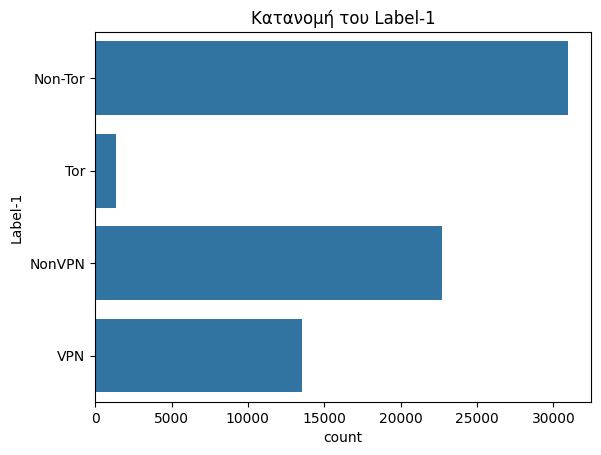

In [6]:
# Οπτικοποίηση της κατανομής του 'Label-1'
sns.countplot(data['Label-1'])
plt.title('Κατανομή του Label-1')
plt.show()

In [7]:
# Διάσπαση των δεδομένων σε χαρακτηριστικά και ετικέτες
X = data.drop(['Label-1', 'Label-2', 'Src_IP', 'Dst_IP'], axis=1)
y = data['Label-1']

# Διάσπαση του συνόλου δεδομένων σε σύνολα εκπαίδευσης και δοκιμής
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Κανονικοποίηση των χαρακτηριστικών
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Δημιουργία του Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Πραγματοποίηση προβλέψεων
y_pred = rf_model.predict(X_test)

In [8]:
# Αξιολόγηση του μοντέλου
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[9254    4    0    8]
 [  14 6639   14  139]
 [   1   43  381    0]
 [  10  319    4 3744]]
              precision    recall  f1-score   support

     Non-Tor       1.00      1.00      1.00      9266
      NonVPN       0.95      0.98      0.96      6806
         Tor       0.95      0.90      0.92       425
         VPN       0.96      0.92      0.94      4077

    accuracy                           0.97     20574
   macro avg       0.97      0.95      0.96     20574
weighted avg       0.97      0.97      0.97     20574



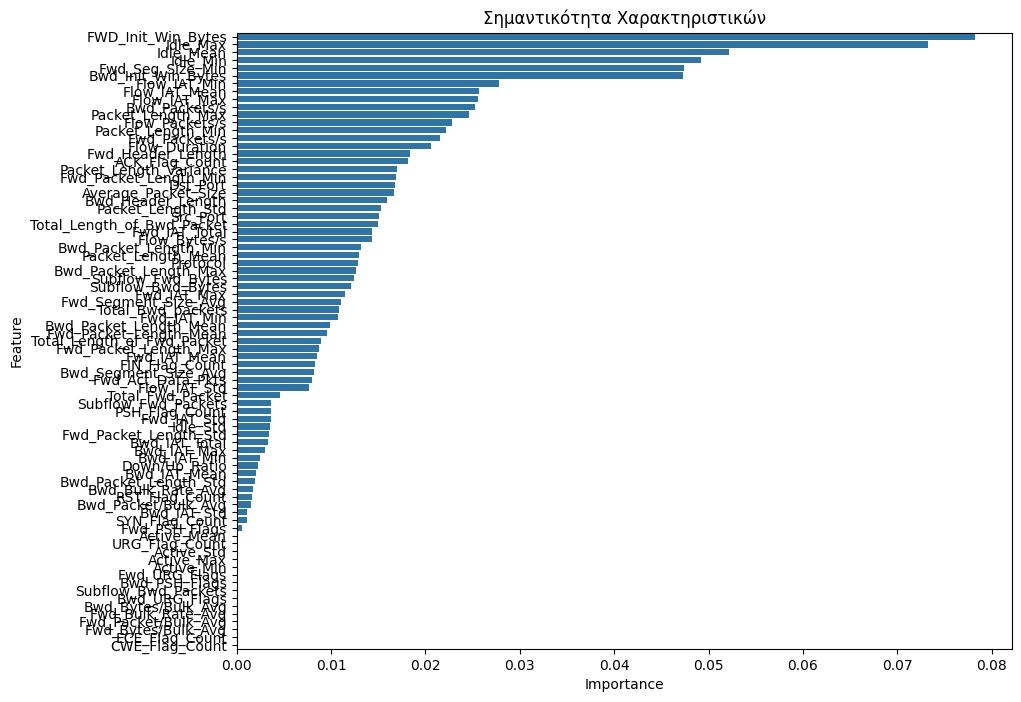

In [9]:
# Σημαντικότητα Χαρακτηριστικών
feature_importances = rf_model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Οπτικοποίηση σημαντικότητας χαρακτηριστικών
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Σημαντικότητα Χαρακτηριστικών')
plt.show()